## Module 2 Final Project Submission
* Name: Vivienne DiFrancesco
* Pace: Full Time
* Instructor: James Irving

# Introduction

# Obtaining the data

In [1]:
# Importing libraries that I will use
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick
%matplotlib inline

# Setting default seaborn setting for my visuals
sns.set(style="whitegrid")

# Supressing warnings
import warnings
warnings.filterwarnings('ignore')

# Importing the statsmodels packages I will use
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Importing scikit learn packages I will use
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score

In [2]:
# Setting pandas to display max columns and rows
pd.set_option('display.max_columns', 0)
pd.set_option('display.max_rows', None)

# Turning off scientific notation in pandas
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [3]:
# Loading in the data
df = pd.read_csv('kc_house_data.csv')
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.000,3,1.000,1180,5650,1.000,nan,0.000,3,7,1180,0.0,1955,0.000,98178,47.511,-122.257,1340,5650
1,6414100192,12/9/2014,538000.000,3,2.250,2570,7242,2.000,0.000,0.000,3,7,2170,400.0,1951,1991.000,98125,47.721,-122.319,1690,7639
2,5631500400,2/25/2015,180000.000,2,1.000,770,10000,1.000,0.000,0.000,3,6,770,0.0,1933,nan,98028,47.738,-122.233,2720,8062
3,2487200875,12/9/2014,604000.000,4,3.000,1960,5000,1.000,0.000,0.000,5,7,1050,910.0,1965,0.000,98136,47.521,-122.393,1360,5000
4,1954400510,2/18/2015,510000.000,3,2.000,1680,8080,1.000,0.000,0.000,3,8,1680,0.0,1987,0.000,98074,47.617,-122.045,1800,7503


When I attempted to set the index I used the verify_integrity=True parameter and got an error that there were duplicate keys. That is how I knew that there were houses that had been sold multiple times in the dataset. I saved those duplicate items as their own dataframe to be able to return to later for EDA.

In [4]:
# Making a new dataframe to look at later of houses sold multiple times
houses_resold = df[df.duplicated(keep=False, subset=['id'])]
houses_resold.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
93,6021501535,7/25/2014,430000.000,3,1.500,1580,5000,1.000,0.000,0.000,3,8,1290,290.0,1939,0.000,98117,47.687,-122.386,1570,4500
94,6021501535,12/23/2014,700000.000,3,1.500,1580,5000,1.000,0.000,0.000,3,8,1290,290.0,1939,0.000,98117,47.687,-122.386,1570,4500
313,4139480200,6/18/2014,1380000.000,4,3.250,4290,12103,1.000,0.000,3.000,3,11,2690,1600.0,1997,0.000,98006,47.550,-122.102,3860,11244
314,4139480200,12/9/2014,1400000.000,4,3.250,4290,12103,1.000,0.000,3.000,3,11,2690,1600.0,1997,0.000,98006,47.550,-122.102,3860,11244
324,7520000520,9/5/2014,232000.000,2,1.000,1240,12092,1.000,nan,0.000,3,6,960,280.0,1922,1984.000,98146,47.496,-122.352,1820,7460


In [5]:
# Set the index to the id
df.set_index('id', inplace=True)

In [6]:
# Checking out the length and columns
df.shape

(21597, 20)

In [7]:
# Checking the data types and where there might be nulls
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21597 entries, 7129300520 to 1523300157
Data columns (total 20 columns):
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(8), int64(10), object(2)
memory usage: 3.5+ MB


# Scrubbing the data

## Addressing the price column

I started with the price column since that is the target. I wanted to get to know the data a little using describe(). I looked at value_counts() to make sure there weren't issues with rogue values like 0000 or something that would not register as nulls.

In [8]:
# Making price an integer instead of a float
df.price = df.price.astype('int64')

In [9]:
# Checking the stats for the column to see if everything looks normal
df.price.describe()

count     21597.000
mean     540296.574
std      367368.140
min       78000.000
25%      322000.000
50%      450000.000
75%      645000.000
max     7700000.000
Name: price, dtype: float64

In [10]:
# Double checking that there aren't rogue values hiding in the data
df.price.value_counts()[:20]

450000    172
350000    172
550000    159
500000    152
425000    150
325000    148
400000    145
375000    138
300000    133
525000    131
250000    130
475000    120
330000    119
650000    117
275000    113
415000    111
315000    111
600000    110
390000    110
280000    109
Name: price, dtype: int64

## Dealing with NA values

I then turned to the other columns to deal with NA values. I filled the NA values, cast them to the correct data type, and then used value_counts() to check for rogue entries that may have been missed.

In [11]:
# Looking at all NA values in all columns
df.isna().sum()

date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

> I tried mapping the entries that were missing waterfront and it seems as if some of the entries would be waterfront properties. I decided to fill the null values based on the ratio of 0 and 1 that are already in the dataset.

In [12]:
# Creating a sub-dataframe of the missing entries to use for visualizing
waterfront_check = df.copy()
waterfront_check = waterfront_check[waterfront_check['waterfront'].isna()]

In [13]:
# Saving the file

# waterfront_check.to_csv(r'C:\Users\drudi\DataScience\Module02\FinalProject\waterfront_check.csv')

This map was created using the waterfront_check dataframe loaded into Tableau Public. This screenshot is a zoomed in view to better see individual entries as an example. The full image can be viewed and downloaded from https://public.tableau.com/profile/vivienne4370 

<img src="waterfrontcheck.png">

In [14]:
# Checking the percentages of the different values
df.waterfront.value_counts(normalize=True)

0.000   0.992
1.000   0.008
Name: waterfront, dtype: float64

In [15]:
# Checking value counts before filling the missing values
df.waterfront.value_counts()

0.000    19075
1.000      146
Name: waterfront, dtype: int64

In [16]:
df_test = df.copy()

In [17]:
# Setting the probability ratios based on the value counts
prob = df.waterfront.value_counts(normalize=True).values

# Setting a seed so that the random results are the same every time
np.random.seed(123)

# Filling the missing values with either 0 or 1 using the probability
df["waterfront"] = df["waterfront"].apply(lambda x: 
                                          np.random.choice([0, 1], p=prob) 
                                          if (np.isnan(x)) else x)

In [18]:
# Making sure the value counts changed appropriately 
# and there are no nulls left
df["waterfront"].value_counts(normalize=True, dropna=False)

0.000   0.992
1.000   0.008
Name: waterfront, dtype: float64

In [20]:
# Changing the datatype
df.waterfront = df.waterfront.astype('int64')

> I dropped the view column since it is not clear what this data represents. It does not represent the views from the house but likely has something to do with listing views. Without knowing what it could mean, I dropped it to avoid any confusion from the column.

In [21]:
# Filling NA values with 0
df.drop(columns='view', inplace=True)

> I decided to fill the yr_renovated columns with zeros and just assume that if the value is null that it means the house has not been renovated.

In [22]:
# Filling NA values with 0
df.yr_renovated.fillna(0, inplace=True)

In [26]:
# Checking for rogue values
df.yr_renovated.value_counts()

0       20853
2014       73
2003       31
2013       31
2007       30
2005       29
2000       29
2004       22
1990       22
2009       21
2006       20
1989       20
2002       17
1998       16
1984       16
1991       16
1999       15
2008       15
2010       15
2001       15
1983       15
1986       14
1985       14
1987       14
2015       14
1994       14
1992       13
1995       12
1993       12
1997       12
1996       11
1988       11
1970        9
2011        9
1980        8
2012        8
1982        8
1979        7
1977        7
1968        7
1975        5
1964        5
1963        4
1969        4
1981        4
1965        4
1973        4
1955        3
1956        3
1972        3
1978        3
1960        3
1958        3
1945        3
1962        2
1967        2
1957        2
1974        2
1940        2
1948        1
1959        1
1934        1
1971        1
1954        1
1950        1
1976        1
1953        1
1951        1
1946        1
1944        1
Name: yr_renovated, 

In [24]:
# Changing the datatype
df.yr_renovated = df.yr_renovated.astype('int64')

In [25]:
# Verifying that all NAs were dealt with
df.isna().sum()

date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

## Checking for strange values in other columns

I looked through the rest of my columns for rogue entries and to generally better get to know my data.

In [27]:
# Looking at columns and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21597 entries, 7129300520 to 1523300157
Data columns (total 19 columns):
date             21597 non-null object
price            21597 non-null int64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       21597 non-null int64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     21597 non-null int64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(4), int64(13), object(2)
memory usage: 3.3+ MB


In [28]:
# Checking for any strange values
df.date.value_counts()[:20]

6/23/2014     142
6/26/2014     131
6/25/2014     131
7/8/2014      127
4/27/2015     126
3/25/2015     123
7/9/2014      121
4/28/2015     121
4/14/2015     121
4/22/2015     121
4/21/2015     119
6/24/2014     119
10/28/2014    117
8/26/2014     117
7/14/2014     116
5/20/2014     116
7/1/2014      115
8/20/2014     114
6/17/2014     113
4/29/2015     113
Name: date, dtype: int64

> There is an entry with 33 bedrooms. I'm going to leave it for now and deal with it later when I do outlier removal.

In [29]:
# Checking for any strange values
df.bedrooms.value_counts()

3     9824
4     6882
2     2760
5     1601
6      272
1      196
7       38
8       13
9        6
10       3
11       1
33       1
Name: bedrooms, dtype: int64

In [30]:
# Checking for any strange values
df.bathrooms.value_counts()

2.500    5377
1.000    3851
1.750    3048
2.250    2047
2.000    1930
1.500    1445
2.750    1185
3.000     753
3.500     731
3.250     589
3.750     155
4.000     136
4.500     100
4.250      79
0.750      71
4.750      23
5.000      21
5.250      13
5.500      10
1.250       9
6.000       6
5.750       4
0.500       4
8.000       2
6.250       2
6.750       2
6.500       2
7.500       1
7.750       1
Name: bathrooms, dtype: int64

In [31]:
# Checking for any strange values
df.sqft_living.value_counts()[:20]

1300    138
1400    135
1440    133
1660    129
1010    129
1800    129
1820    128
1480    125
1720    125
1540    124
1560    124
1320    122
1250    120
1580    119
1200    118
1370    118
1650    117
1900    117
1780    117
1680    116
Name: sqft_living, dtype: int64

In [32]:
# Checking for any strange values
df.sqft_lot.value_counts()[:20]

5000    358
6000    290
4000    251
7200    220
7500    119
4800    119
4500    114
8400    111
9600    109
3600    103
9000     93
3000     84
5100     78
7000     76
8000     76
5500     73
8100     72
7800     69
4080     67
7700     66
Name: sqft_lot, dtype: int64

In [33]:
# Checking for any strange values
df.floors.value_counts()

1.000    10673
2.000     8235
1.500     1910
3.000      611
2.500      161
3.500        7
Name: floors, dtype: int64

In [34]:
# Checking for any strange values
df.condition.value_counts()

3    14020
4     5677
5     1701
2      170
1       29
Name: condition, dtype: int64

In [35]:
# Checking for any strange values
df.grade.value_counts()

7     8974
8     6065
9     2615
6     2038
10    1134
11     399
5      242
12      89
4       27
13      13
3        1
Name: grade, dtype: int64

In [36]:
# Checking for any strange values
df.sqft_above.value_counts()[:20]

1300    212
1010    210
1200    206
1220    192
1140    184
1400    180
1060    178
1180    177
1340    176
1250    174
1320    172
1100    164
1080    161
1040    160
1240    160
1150    159
1330    158
1260    155
1440    155
1120    154
Name: sqft_above, dtype: int64

> There are question mark values for sqft_basement. I decided to fill them with zeros.

In [37]:
# Checking for any strange values
df.sqft_basement.value_counts()[:20]

0.0       12826
?           454
600.0       217
500.0       209
700.0       208
800.0       201
400.0       184
1000.0      148
300.0       142
900.0       142
200.0       105
750.0       104
480.0       103
530.0       103
450.0       103
720.0        98
620.0        90
580.0        84
840.0        83
420.0        81
Name: sqft_basement, dtype: int64

In [38]:
# Replacing the ? entries with 0
df.sqft_basement = df.sqft_basement.map(lambda x: int(float(x.replace('?', '0'))))

In [39]:
# Setting the datatype to be an integer
df.sqft_basement = df.sqft_basement.astype('int64')

In [40]:
# Checking for any strange values again
df.sqft_basement.value_counts()[:20]

0       13280
600       217
500       209
700       208
800       201
400       184
1000      148
900       142
300       142
200       105
750       104
530       103
480       103
450       103
720        98
620        90
580        84
840        83
420        81
860        79
Name: sqft_basement, dtype: int64

In [41]:
# Checking for any strange values
df.yr_built.value_counts()[:20]

2014    559
2006    453
2005    450
2004    433
2003    420
2007    417
1977    417
1978    387
1968    381
2008    367
1967    350
1979    343
1959    334
1990    317
1962    312
2001    305
1954    305
1987    294
1989    290
1969    280
Name: yr_built, dtype: int64

In [42]:
# Checking for any strange values
df.zipcode.value_counts()[:20]

98103    602
98038    589
98115    583
98052    574
98117    553
98042    547
98034    545
98118    507
98023    499
98006    498
98133    493
98059    468
98058    455
98155    446
98074    441
98033    432
98027    412
98125    409
98056    406
98053    403
Name: zipcode, dtype: int64

In [46]:
# Checking for any strange values
df.lat.value_counts()

47.662    17
47.549    17
47.532    17
47.685    17
47.671    16
47.689    16
47.696    16
47.665    15
47.690    15
47.686    15
47.684    15
47.540    15
47.552    14
47.685    14
47.543    14
47.532    14
47.540    14
47.673    14
47.544    14
47.684    14
47.673    14
47.708    14
47.553    14
47.665    14
47.691    14
47.637    14
47.534    14
47.653    14
47.540    14
47.682    14
47.531    13
47.566    13
47.675    13
47.686    13
47.692    13
47.688    13
47.697    13
47.550    13
47.697    13
47.676    13
47.637    13
47.629    13
47.680    13
47.668    13
47.698    13
47.697    13
47.639    13
47.654    12
47.568    12
47.540    12
47.543    12
47.691    12
47.517    12
47.699    12
47.773    12
47.695    12
47.703    12
47.551    12
47.623    12
47.722    12
47.689    12
47.638    12
47.733    12
47.630    12
47.729    12
47.637    12
47.687    12
47.669    12
47.515    12
47.685    12
47.512    12
47.563    12
47.634    12
47.571    12
47.533    12
47.674    12
47.552    12

In [47]:
# Checking for any strange values
df.long.value_counts()

-122.290    115
-122.300    111
-122.362    104
-122.291    100
-122.372     99
-122.363     99
-122.288     98
-122.357     96
-122.284     95
-122.172     94
-122.365     94
-122.306     93
-122.346     93
-122.351     92
-122.304     92
-122.348     92
-122.299     92
-122.375     92
-122.295     91
-122.350     90
-122.285     90
-122.292     90
-122.352     89
-122.289     89
-122.298     88
-122.359     88
-122.384     87
-122.317     86
-122.316     86
-122.301     86
-122.354     85
-122.287     85
-122.361     85
-122.391     85
-122.353     85
-122.385     84
-122.311     84
-122.189     83
-122.371     83
-122.286     83
-122.378     81
-122.370     81
-122.388     81
-122.349     81
-122.340     80
-122.387     79
-122.331     78
-122.358     78
-122.308     78
-122.307     78
-122.337     77
-122.360     76
-122.356     76
-122.297     76
-122.369     75
-122.319     75
-122.174     75
-122.339     75
-122.324     75
-122.302     75
-122.321     74
-122.379     74
-122.315

In [48]:
df.sqft_living15.value_counts()[:20]

1540    197
1440    195
1560    192
1500    180
1460    169
1580    167
1610    166
1800    166
1720    166
1620    164
1510    164
1760    163
1480    160
1410    159
1550    158
1820    157
1680    157
1670    157
1520    155
1660    155
Name: sqft_living15, dtype: int64

In [49]:
df.sqft_lot15.value_counts()[:20]

5000    427
4000    356
6000    288
7200    210
4800    145
7500    142
8400    116
4500    111
3600    111
5100    109
4080    106
8000    105
9600     98
8100     93
9000     92
7800     86
7700     85
5500     81
5400     71
6600     68
Name: sqft_lot15, dtype: int64

In [50]:
# Final check that all the data types are good
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21597 entries, 7129300520 to 1523300157
Data columns (total 19 columns):
date             21597 non-null object
price            21597 non-null int64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       21597 non-null int64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null int64
yr_built         21597 non-null int64
yr_renovated     21597 non-null int64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(4), int64(14), object(1)
memory usage: 3.3+ MB


## Adding Columns

There are some columns I want to add based on the data I have in other columns that I think may be of more use to my model than the current columns. For example the sqft_basement column has mostly 0 entries. It may be more useful to have a column that indicates whether a basement exists or not. Also with dates, it may be useful to have columns based on month or season sold.

In [52]:
# Spliting the month out of the date column into a new column of its own
df['month_sold'] = df['date'].map(lambda x: x.replace('/', ' ').split()[0])

In [53]:
# Casting the new column to be an integer
df['month_sold'] = df['month_sold'].astype('int64')

In [54]:
# Checking the values of the new column
df.month_sold.value_counts()

5     2414
4     2229
7     2211
6     2178
8     1939
10    1876
3     1875
9     1771
12    1470
11    1409
2     1247
1      978
Name: month_sold, dtype: int64

In [55]:
# Function that takes the day from the date column 
# and assigns a week of the month

def week_of_month(x):
#     Splitting the day out from the date
    day = int(x.replace('/', ' ').split()[1])
    
#     Assigning the week based on the day
    if day < 8:
        week = 1
    elif day < 15 and day > 7:
        week = 2
    elif day < 22 and day > 14:
        week = 3
    elif day < 29 and day > 21:
        week = 4
    else:
        week = 5
        
    return week

In [56]:
# Adding the new column by applying the function above
df['week_sold'] = df['date'].map(week_of_month)

In [57]:
# Checking the values of the new column
df.week_sold.value_counts()

4    5212
2    5093
3    4934
1    4839
5    1519
Name: week_sold, dtype: int64

In [58]:
# Function that takes the month sold and assigns the month to a season

def season_sold(x):
    
#     Assigning season based on month
    if x > 2 and x < 6:
        season = 1
    elif x > 5 and x < 9:
        season = 2
    elif x > 8 and x < 12:
        season = 3
    else:
        season = 4
        
    return season

In [59]:
# Creating the new column by applying the function above
df['season_sold'] = df['month_sold'].map(season_sold)

In [60]:
# Checking the values of the new column
df.season_sold.value_counts()

1    6518
2    6328
3    5056
4    3695
Name: season_sold, dtype: int64

In [61]:
# Creating new renovated column
df['was_renovated'] = df['yr_renovated'].map(lambda x: x!=0)

In [62]:
# Casting the new column to be an integer
df['was_renovated'] = df['was_renovated'].astype('int64')

In [63]:
# Checking the values of the new column
df.was_renovated.value_counts()

0    20853
1      744
Name: was_renovated, dtype: int64

In [64]:
# Creating new basement column
df['has_basement'] = df['sqft_basement'].map(lambda x: x!=0 )

In [65]:
# Casting the new column to be an integer
df['has_basement'] = df['has_basement'].astype('int64')

In [66]:
# Checking the values of the new column
df.has_basement.value_counts()

0    13280
1     8317
Name: has_basement, dtype: int64

In [67]:
# Dropped the date column since the values will be hard to model with
df.drop(columns='date', inplace=True)

In [68]:
# Checking all my columns at data types
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21597 entries, 7129300520 to 1523300157
Data columns (total 23 columns):
price            21597 non-null int64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       21597 non-null int64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null int64
yr_built         21597 non-null int64
yr_renovated     21597 non-null int64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
month_sold       21597 non-null int64
week_sold        21597 non-null int64
season_sold      21597 non-null int64
was_renovated    21597 non-null int64
has_basement     21597 non-null i

# Exploring the data

## EDA Question 1: How does location affect house prices, sizes, and other metrics? 

I was curious to do some exploration with the latitude and longitude to map the houses and look at various factors like price, home square footage, and lot square footage. The visuals here were created using my cleaned data loaded into Tableau Public. The full images can be viewed and downloaded from https://public.tableau.com/profile/vivienne4370

In [107]:
# Saving the file to use
# df.to_csv(r'C:\Users\drudi\DataScience\Module02\FinalProject\cleaned_data.csv')

### Location and price

In [ ]:
# <img src="waterfrontcheck.png">

## Checking the distribution of prices

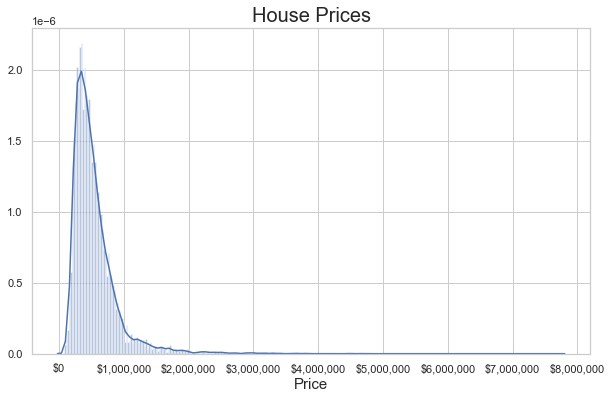

In [69]:
fig, ax = plt.subplots(figsize=(10,6))
sns.distplot(df['price'], bins='auto')

fmt_money = '${x:,.0f}'
tick_money = mtick.StrMethodFormatter(fmt_money)
ax.xaxis.set_major_formatter(tick_money)

ax.set_xlabel('Price', fontsize=15)
ax.set_title('House Prices', fontsize=20);

>There is a large tail to the distribution of prices which is to be expected since there are of course a few houses that are much more expensive than the majority of houses. I will address all the outliers at a later point, but it's good to see that there looks to still be good normality in the prices despite the long tail.

## Checking linearity, normality distribution, and choosing categorical columns

In [105]:
def explore_plot(df, col, target='price'):
    g = sns.jointplot(data=df, x=col, y=target, kind='reg', height=6, 
                      joint_kws={'line_kws':{'color':'red'}})

    plt.suptitle(f'{col} and {target}', fontsize=20, y=1.05)
    return g

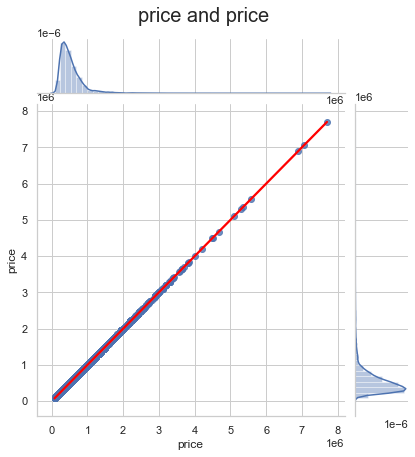

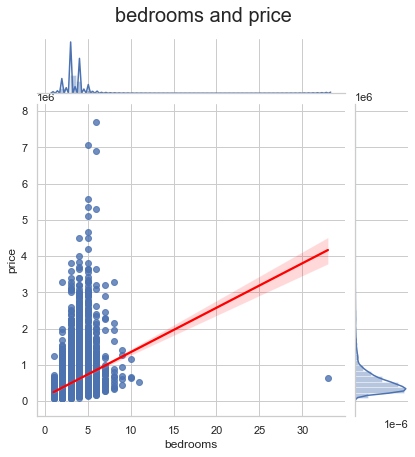

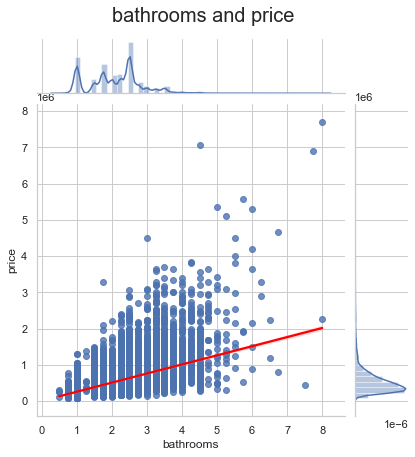

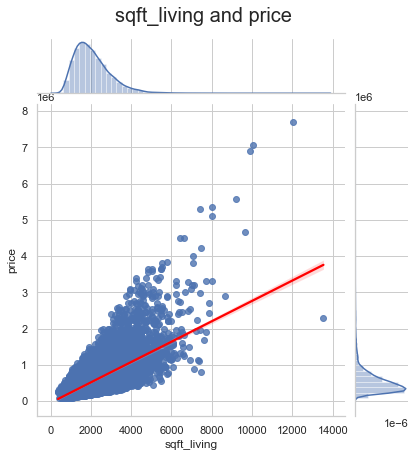

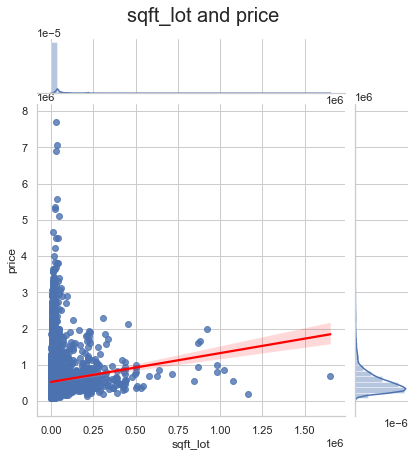

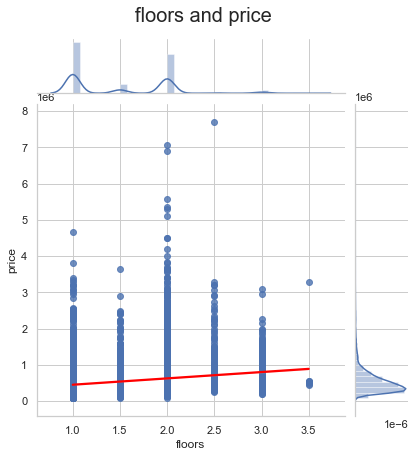

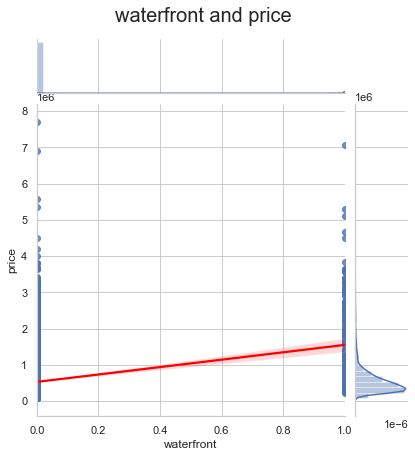

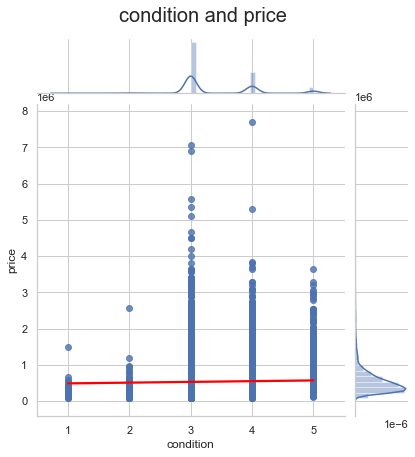

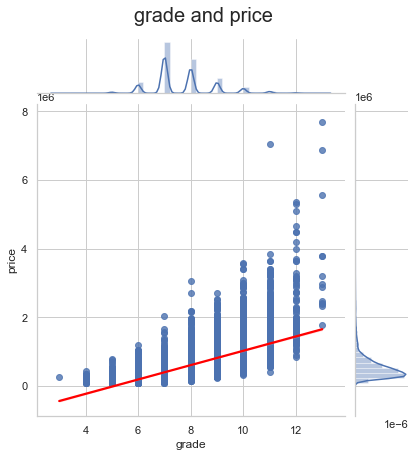

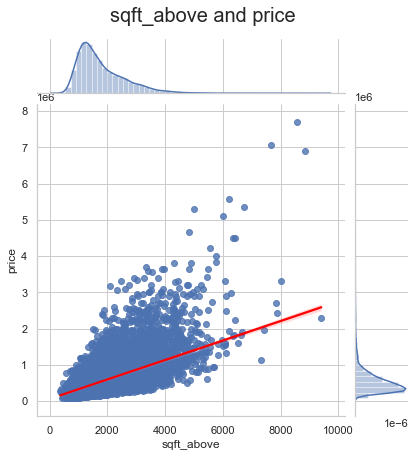

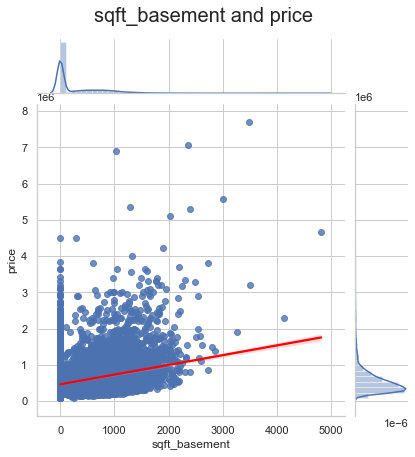

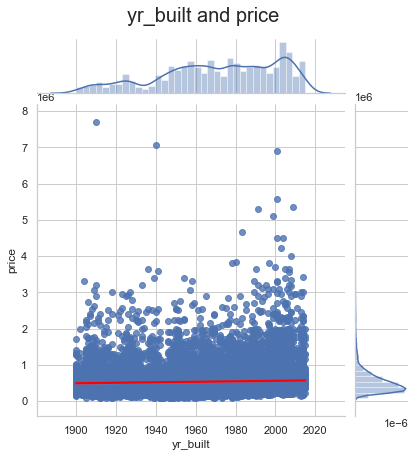

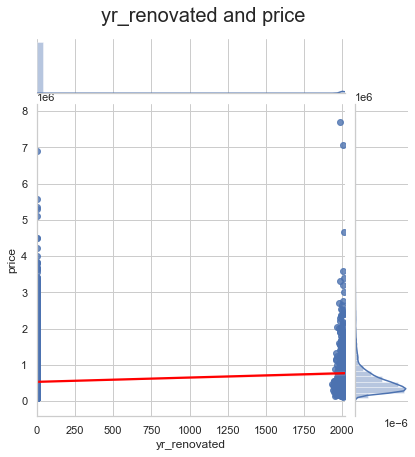

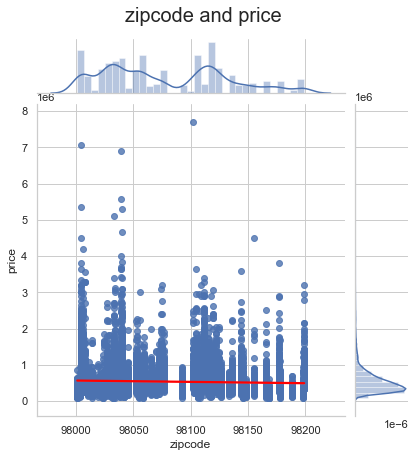

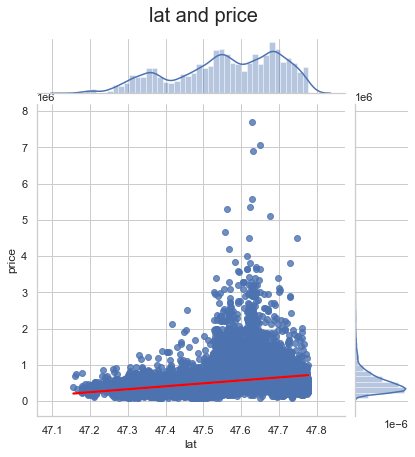

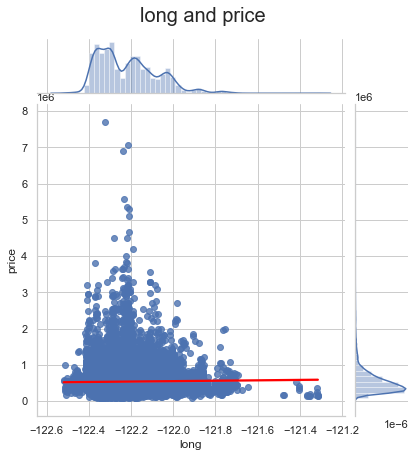

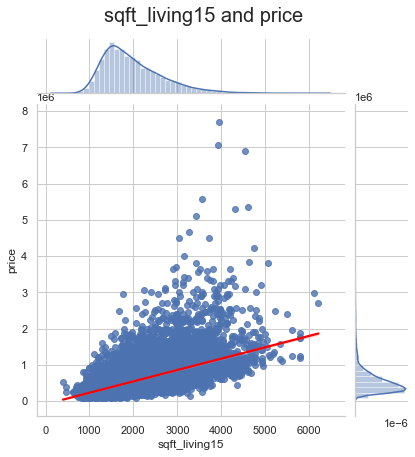

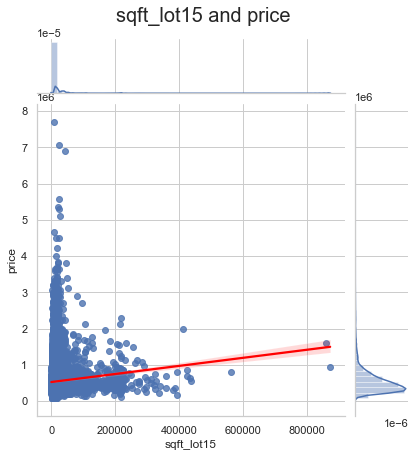

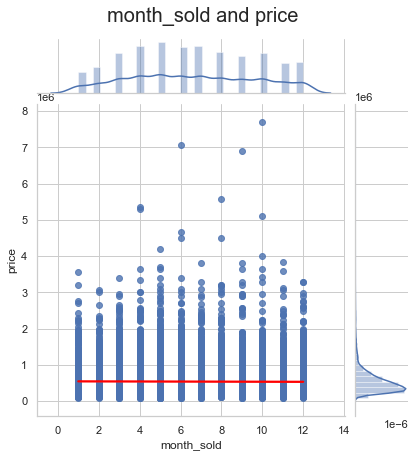

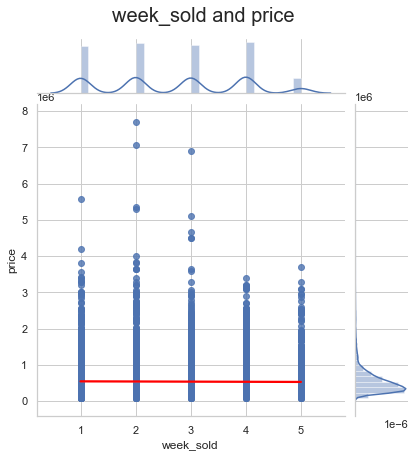

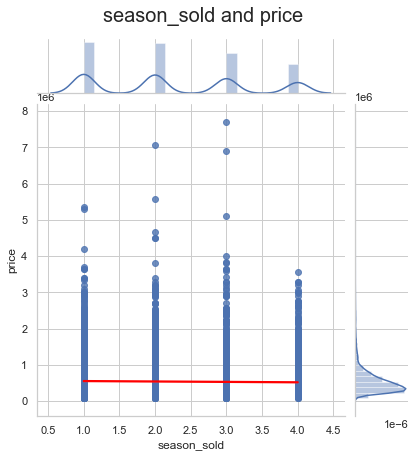

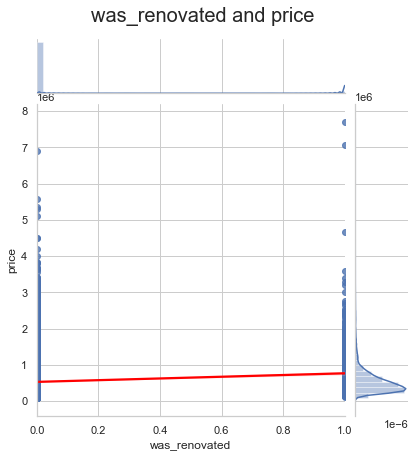

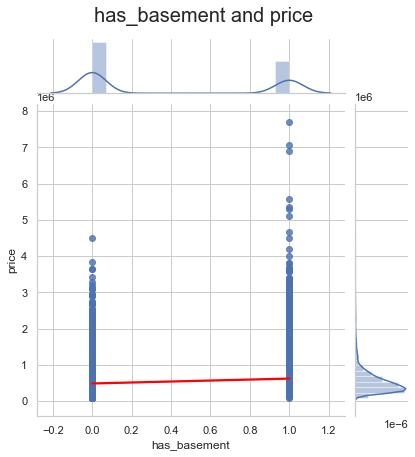

In [106]:
cols = list(df.columns)
for col in cols:
    explore_plot(df, col)